<a href="https://colab.research.google.com/github/RajK853/tum-adlr-ss21-11/blob/main/notebook/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup for Google Colab
The sections below are required to execute this notebook in Google Colab. If you are not executing this notebook in Google colab, you can skip these sections.

## Load Tensorflow
In Google Colab, tensorflow can be easily selected using the given magic command:

In [1]:
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


## Cloning the repo
The shell command below clones the git repo if the local repo directory does not exit. Otherwise, it simply pulls the updated version.

In [ ]:
%%shell
REPOSRC=https://github.com/RajK853/tum-adlr-ss21-11.git
LOCALREPO=/adlr
 
LOCALREPO_VC_DIR=$LOCALREPO/.git
 
if [ ! -d $LOCALREPO_VC_DIR ]
then
    git clone $REPOSRC $LOCALREPO
else
    cd $LOCALREPO
    git pull $REPOSRC
fi

## Setting the working directory
By default, the working directory is `./notebook/` for Jupyter Lab. Therefore, we set the working directory to that path also in Google Colab so that the later cells are compatible with both Google Colab and Jupyter Lab. 

In [ ]:
%cd /adlr/notebook

## Mount Google Drive
Mount your Google drive to access the data set located in your Google drive.

In [ ]:
try:
    from google.colab import drive
    drive.mount("/content/drive")
except ModuleNotFoundError:
    pass

# Implementation
The sections below works for both Google Colab and Jupyter Notebook.

In [1]:
%%time
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf

CPU times: user 1.6 s, sys: 743 ms, total: 2.35 s
Wall time: 1.25 s


In [2]:
%load_ext tensorboard

In [3]:
%cd ".."
from src import losses
from src.models import u_dense_net
from src.generators import DataGen
from src.callbacks import ImageSaverCallback
from src.load import get_values_sql, compressed2img, object2numeric_array

/home/rajk/DIT/ADLR/tum-adlr-ss21-11


# Local functions

In [4]:
def load_world_data(db_path, n_voxels, n_dim):
    worlds = get_values_sql(file=db_path, table="worlds")
    obstacle_images = compressed2img(img_cmp=worlds.obst_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)
    obstacle_images = np.expand_dims(obstacle_images, axis=-1)
    return obstacle_images

def load_data(db_path, path_indexes, n_voxels, n_dim):
    # TODO: Create a generic load function later
    paths = get_values_sql(file=db_path, table='paths', rows=path_indexes)
    path_images = compressed2img(img_cmp=paths.path_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)
    start_images = compressed2img(img_cmp=paths.start_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)
    end_images = compressed2img(img_cmp=paths.end_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)
    # Process images
    start_images = np.expand_dims(start_images, axis=-1)
    end_images = np.expand_dims(end_images, axis=-1)
    path_images = np.expand_dims(path_images, axis=-1)
    return start_images, end_images, path_images

def image2image_callback(batch_indexes, data_dict):
    path_indexes = data_dict["path_rows"][batch_indexes]
    obst_indexes = path_indexes//n_paths_per_world
    obst_batch_data = data_dict["obst_imgs"][obst_indexes]
    goal_batch_data = data_dict["goal_imgs"][batch_indexes]
    path_batch_data = data_dict["path_imgs"][batch_indexes]
    input_batch_data = [np.concatenate([obst_batch_data, goal_batch_data], axis=-1)]
    output_batch_data = [path_batch_data]
    return input_batch_data, output_batch_data

def save_images(index, logs, log_dir):
    batch_inputs = logs["inputs"]
    batch_outputs = logs["true_outputs"]
    batch_predictions = logs["outputs"]
    for i in range(batch_predictions.shape[0]):
        fig, ax = plt.subplots()
        ax.imshow(batch_inputs[i, :, :, 0], origin='lower', cmap='binary')            # Obstacle 
        ax.imshow(batch_inputs[i, :, :, 1], origin='lower', cmap='Greens', alpha=0.3) # Goal
        ax.imshow(batch_outputs[i, :, :, 0], origin='lower', cmap='Blues', alpha=0.5)   # True path
        ax.imshow(batch_predictions[i, :, :, 0], origin='lower', cmap='Reds', alpha=0.3)# Predicted path
        ax.set_xticks([])
        ax.set_yticks([])
        fig.savefig(f"{log_dir}/Image_{index+i}.png")
        plt.close(fig=fig)

def get_loss_func(loss_config):
    loss_name = loss_config.pop("name")
    loss_func = getattr(losses, loss_name, None)
    assert loss_func is not None, f"'{loss_name}' is not a valid loss function!"
    return loss_func(**loss_config)

# Init global variables
> Set `db_path` to the location of the `.db` file located in your local machine or in the Google Drive.

In [5]:
db_path = "SingleSphere02.db"

In [18]:
epochs = 30
batch_size = 64
log_dir = "temp"
n_paths_per_world = 1000

loss_config= {
    "name": "focal",
    "gamma": 2,
    "beta": 0.5,
    "balanced": False,
}

data_config = {
    "n_voxels": 64,
    "n_dim": 2,
}

model_config = {
    "lr": 0.001,
    "input_shape": [64, 64, 2],
    "num_db": 3,
    "convs_per_db": 2,
    "growth_rate": 32,
    "num_channels": 32,
}

path_row_dict = {
    "train": (0, 3000000, 100),
    "validation": (3000000, 4000000, 200),
    "test": (4000000, 4100000, 250),
}

In [8]:
path_rows = {
    key: np.arange(*value) 
    for key, value in path_row_dict.items()
}

# Load training and validation data

In [9]:
%%time
obst_imgs = load_world_data(db_path, **data_config)
train_start_imgs, train_end_imgs, train_path_imgs = load_data(db_path, path_rows["train"], **data_config)
train_path_imgs = train_path_imgs.astype("float32")
train_goal_imgs = train_start_imgs + train_end_imgs

validation_start_imgs, validation_end_imgs, validation_path_imgs = load_data(db_path, path_rows["validation"], **data_config)
validation_path_imgs = validation_path_imgs.astype("float32")
validation_goal_imgs = validation_start_imgs + validation_end_imgs

test_start_imgs, test_end_imgs, test_path_imgs = load_data(db_path, path_rows["test"], **data_config)
test_path_imgs = test_path_imgs.astype("float32")
test_goal_imgs = test_start_imgs + test_end_imgs

del train_start_imgs, train_end_imgs, validation_start_imgs, validation_end_imgs, test_start_imgs, test_end_imgs

CPU times: user 1.97 s, sys: 279 ms, total: 2.25 s
Wall time: 2.25 s


In [10]:
train_data_dict = {
    "path_rows": path_rows["train"],
    "obst_imgs": obst_imgs,
    "goal_imgs": train_goal_imgs,
    "path_imgs": train_path_imgs
}

validation_data_dict = {
    "path_rows": path_rows["validation"],
    "obst_imgs": obst_imgs,
    "goal_imgs": validation_goal_imgs,
    "path_imgs": validation_path_imgs
}

test_data_dict = {
    "path_rows": path_rows["test"],
    "obst_imgs": obst_imgs,
    "goal_imgs": test_goal_imgs,
    "path_imgs": test_path_imgs
}

In [11]:
train_data_gen = DataGen(train_data_dict, callback=image2image_callback, batch_size=batch_size)
validation_data_gen = DataGen(validation_data_dict, callback=image2image_callback, batch_size=batch_size)
test_data_gen = DataGen(test_data_dict, callback=image2image_callback, batch_size=batch_size)

# Visualize Graph
> Make sure to turn on the automatic update option in the Tensorboard by checing the option `Settings`->`Reload Data`.

In [12]:
%cd "notebook"
!rm -rf "temp"
%tensorboard --logdir "temp"

/home/rajk/DIT/ADLR/tum-adlr-ss21-11/notebook


# Load U-DenseNet model

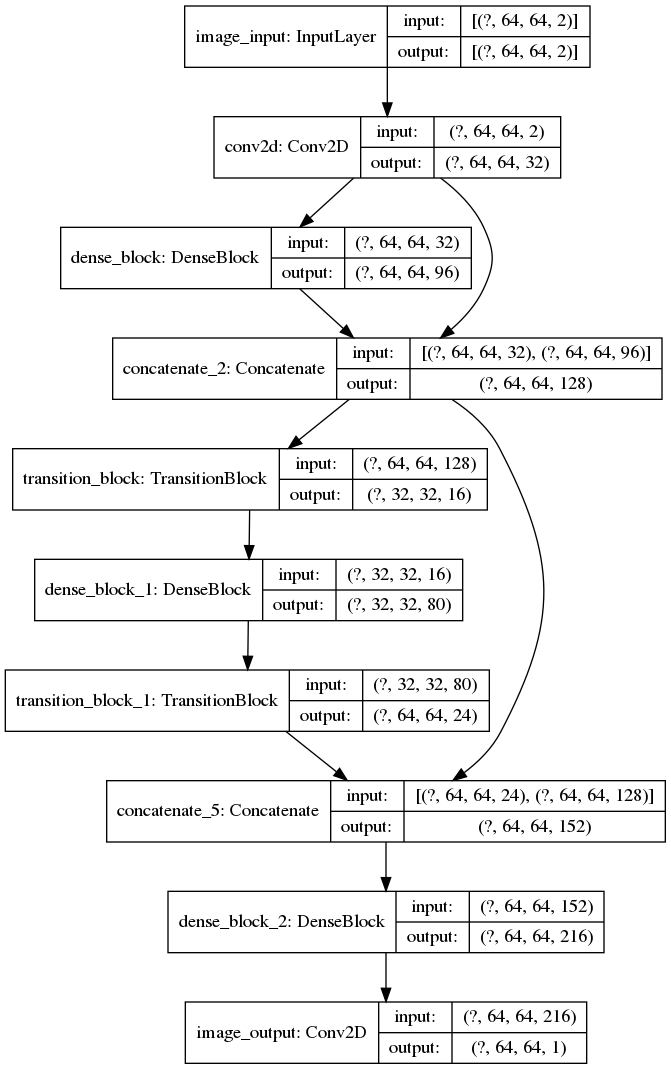

In [15]:
tf.keras.backend.clear_session()
lr = model_config.pop("lr", 1e-3)
denseNet = u_dense_net(**model_config)
loss_func = get_loss_func(loss_config)
optimizer = tf.keras.optimizers.Adam(lr=lr)
denseNet.compile(optimizer=optimizer, loss=loss_func)
os.makedirs(log_dir, exist_ok=True)
tf.keras.utils.plot_model(denseNet, to_file=os.path.join(log_dir, 'model.png'), show_shapes=True)    # Saves model graph as model.png
# denseNet.summary()

# Train U-DenseNet model

In [19]:
%%time
train_callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=os.path.join(log_dir, "tb_logs")),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5)
]
history = denseNet.fit(train_data_gen, validation_data=validation_data_gen, epochs=2, callbacks=train_callbacks)

Epoch 1/2
469/469 [==============================] - 109s 233ms/step - loss: 123.2303 - val_loss: 657.0972
Epoch 2/2
469/469 [==============================] - 96s 205ms/step - loss: 103.4438 - val_loss: 108.2894
CPU times: user 2min 30s, sys: 10.5 s, total: 2min 41s
Wall time: 3min 38s


# Test model

In [20]:
predict_callbacks = [ImageSaverCallback(test_data_gen, os.path.join(log_dir, "test_images"), callback=save_images)]
prediction_data = denseNet.predict(test_data_gen, callbacks=predict_callbacks)

Saving 400 images: ████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 16.00% | mean time per iter: 2.27 s | time left: 12:41 |  WARNING:tensorflow:Method (on_predict_batch_end) is slow compared to the batch update (2.033019). Check your callbacks.
Saving 400 images: ████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 32.00% | mean time per iter: 2.24 s | time left: 10:09 |  WARNING:tensorflow:Method (on_predict_batch_end) is slow compared to the batch update (2.098065). Check your callbacks.
Saving 400 images: ████████████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░ 48.00% | mean time per iter: 2.21 s | time left: 07:39 |  WARNING:tensorflow:Method (on_predict_batch_end) is slow compared to the batch update (2.084096). Check your callbacks.
Saving 400 images: ████████████████████████████████░░░░░░░░░░░░░░░░░░ 64.00% | mean time per iter: 2.19 s | time left: 05:15 |  WARNING:tensorflow:Method (on_predict_batch_end) is slow compared to the batch update (2.081471). Check your callbacks.
Saving 4

# Visualize on test data

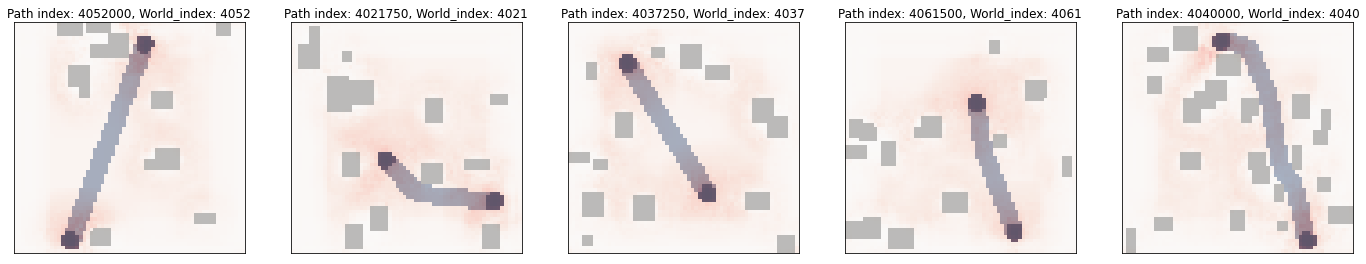

In [21]:
N = 5
path_indexes = np.random.choice(path_rows["test"], size=N)
_, axs = plt.subplots(nrows=1, ncols=N, figsize=((1+N)*4, 10))
for path_i, ax in zip(path_indexes, axs):
    i = np.where(path_rows["test"]==path_i)[0].item()
    obst_i = path_i//n_paths_per_world
    ax.imshow(obst_imgs[obst_i, :, :, 0], origin='lower', cmap='binary')
    ax.imshow(test_goal_imgs[i, :, :, 0], origin='lower', cmap='Greens', alpha=0.3)
    ax.imshow(test_path_imgs[i, :, :, 0], origin='lower', cmap='Blues', alpha=0.5)
    ax.imshow(prediction_data[i, :, :, 0], origin='lower', cmap='Reds', alpha=0.3)
    ax.set_title(f"Path index: {path_i}, World_index: {path_i//n_paths_per_world}")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [22]:
denseNet.save(os.path.join(log_dir, "model.tf"))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: temp/model.tf/assets
